In [1]:
import time
import pandas as pd
import numpy as np
from collections import Counter
from collections import defaultdict
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
import copy
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn.metrics import classification_report, accuracy_score
from subprocess import check_call
from sklearn.tree import export_graphviz
import operator
from dtreeviz.trees import *
from sklearn.datasets import load_iris
# from IPython import display

import sys
sys.path.append('..')

from Libraries.Utils.Global_Utils import *
from Libraries.ClusterMaster import ClusterMaster
from Libraries.DataframeTypeHolder import DataframeTypeHolder
%matplotlib inline

In [2]:
def replace_df_vals(passed_df,replace_dict):
    """
        Uses a hash map to decode dataframe data
    """

    def replace_vals_col(data, decoder):
        return decoder[data]

    df = copy.deepcopy(passed_df)
    for col in df.columns:
        if col in replace_dict.keys():
            df[col] = np.vectorize(replace_vals_col)(
                df[col], replace_dict[col])

    return df

# Returns encoded df and label encoded map
def encode_df(df, objt_cols):

    df = copy.deepcopy(df)
    # ---
    le_map = defaultdict(LabelEncoder)

    # Encoding the variable
    fit = df[objt_cols].apply(lambda x: le_map[x.name].fit_transform(x))

    # Inverse the encoded
    fit.apply(lambda x: le_map[x.name].inverse_transform(x))

    # Using the dictionary to label future data
    df[objt_cols] = df[objt_cols].apply(lambda x: le_map[x.name].transform(x))

    return df, le_map

def decode_df(df,le_map):
    
    df = copy.deepcopy(df)
    decode_cols = list(le_map.keys())
    df[decode_cols] = df[decode_cols].apply(lambda x: le_map[x.name].inverse_transform(x))
    
    return df


def print_encode_map(le):

    print("\nLabel mapping:\n")
    for i, item in enumerate(le.classes_):
        print("\t", item, '-->', i)

    # Draw a line
    print("-"*30, "\n")

In [3]:
iris = load_iris()

In [4]:
iris_df = pd.DataFrame(data=np.c_[iris['data'], iris['target']],
                       columns=iris['feature_names'] + ['species'])
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


In [5]:
# http://archive.ics.uci.edu/ml/datasets/Heart+Disease
replace_dict = dict()

replace_dict["species"] = {0:"Setosa",
                           1:"Versicolor",
                           2:"Virginica"}

iris_df = replace_df_vals(iris_df,replace_dict)
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


In [6]:
df_features = DataframeTypeHolder(iris_df)
df_features.display_all()

Categorical Features: {'species'}

Bool Features: set()

------------------------------------------------------------------------------------------
Numerical Features: {'petal width (cm)', 'petal length (cm)', 'sepal width (cm)', 'sepal length (cm)'}

Integer Features: set()

Float Features: {'petal width (cm)', 'petal length (cm)', 'sepal width (cm)', 'sepal length (cm)'}



In [7]:
iris_df, le_map = encode_df(iris_df, df_features.get_categorical_features())
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [8]:
restore_df = iris_df
iris_df = iris_df.drop(columns=['species'])

In [9]:
iris_df.values.shape

(150, 4)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
sepal length (cm),1,-0.11757,0.871754,0.817941
sepal width (cm),-0.11757,1,-0.42844,-0.366126
petal length (cm),0.871754,-0.42844,1,0.962865
petal width (cm),0.817941,-0.366126,0.962865,1


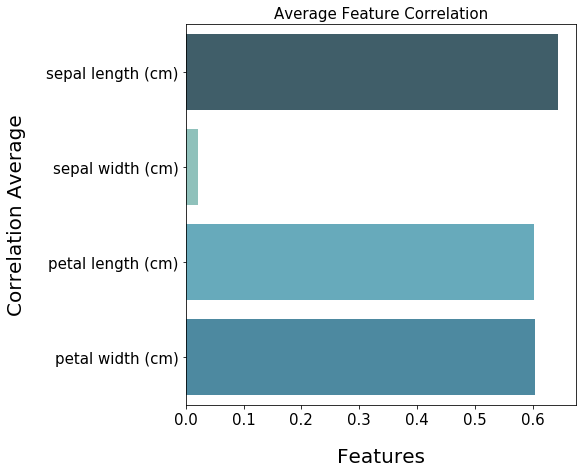

In [10]:
corr_metrics = iris_df.corr()
display(corr_metrics.style.background_gradient())

# Get the correlation means of each feature
corr_feature_means = []
for feature_name in list(corr_metrics.columns):
    corr_feature_means.append(corr_metrics[feature_name].mean())

# Graph rank
display_rank_graph(feature_names=list(corr_metrics.columns),
                   metric=corr_feature_means,
                   title="Average Feature Correlation",
                   y_title="Correlation Average",
                   x_title="Features")


Inspecting scaled results!


,Mean,Standard Dev
sepal length (cm),-4.736952e-16,1.0
sepal width (cm),-7.815970e-16,1.0
petal length (cm),-4.263256e-16,1.0
petal width (cm),-4.736952e-16,1.0


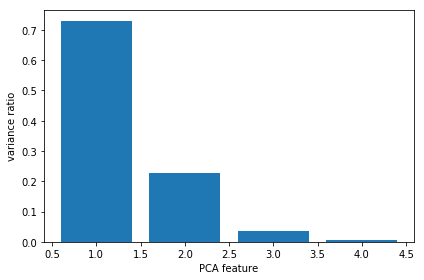

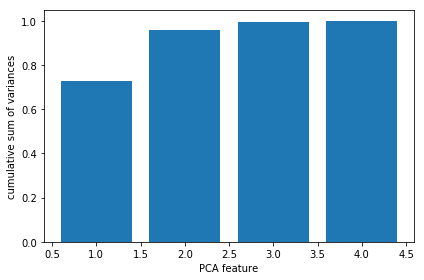


Inspecting applied pca results!


,Mean,Standard Dev
PCA_Feature_1,2.842171e-16,1.708361
PCA_Feature_2,3.848773e-17,0.956049
PCA_Feature_3,4.144833e-17,0.383089
PCA_Feature_4,6.809368e-17,0.143926


After applying pca with a cutoff percentage 0.8% for the cumulative index. Using features 1 to 2
Old shape (150, 4)
New shape (150, 2)

Inspecting re-applied scaled results!


,Mean,Standard Dev
PCA_Feature_1,-4.736952e-17,1.0
PCA_Feature_2,2.960595e-18,1.0


In [11]:
cluster_maintainer = ClusterMaster(df=iris_df,
                                   pca_perc=.8)

Successfully generate Kmeans model on k_val=2
Successfully generate Kmeans model on k_val=3
Successfully generate Kmeans model on k_val=4


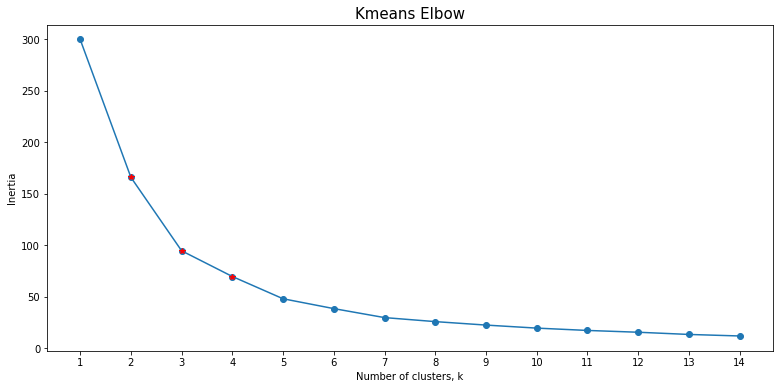

In [12]:
cluster_maintainer.create_kmeans_models_with_elbow_graph()

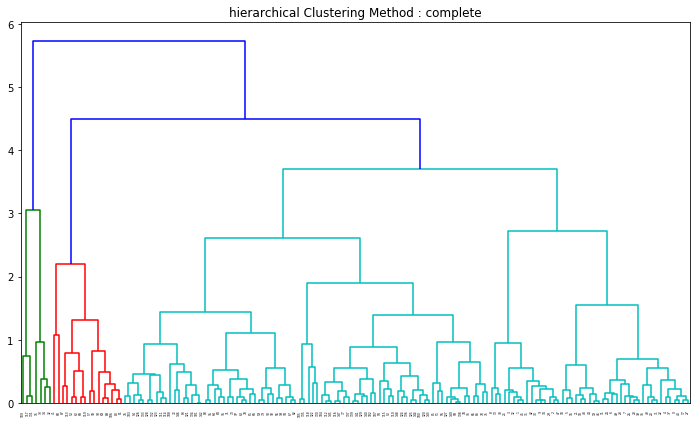

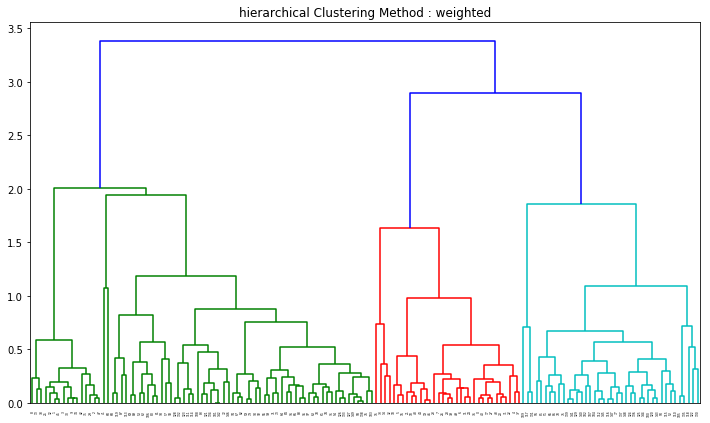

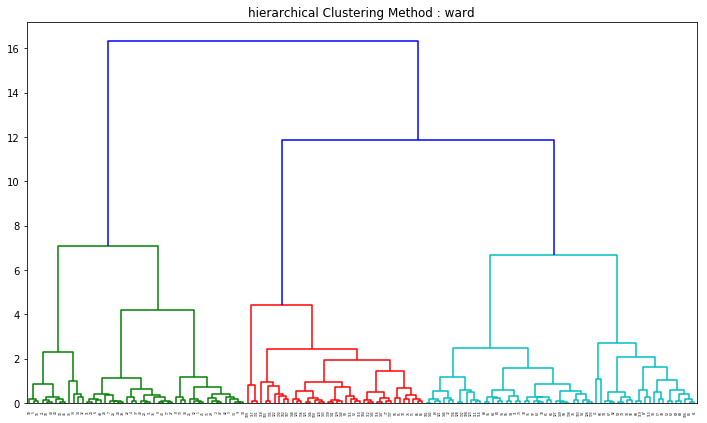

In [13]:
cluster_maintainer.visualize_hierarchical_clustering(linkage_methods=["complete","weighted","ward"])

In [14]:
# cluster_maintainer.create_agglomerative_models(n_cluster_list=5)

In [15]:
cluster_maintainer.create_kmeans_models(n_cluster_list=[8,12])

Successfully generate Kmeans model on pre_defined_k=8
Successfully generate Kmeans model on pre_defined_k=12


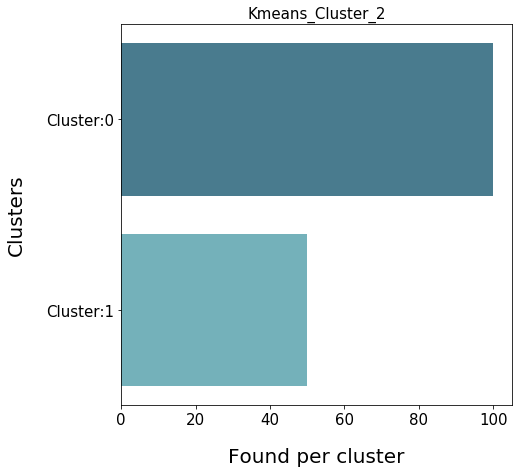

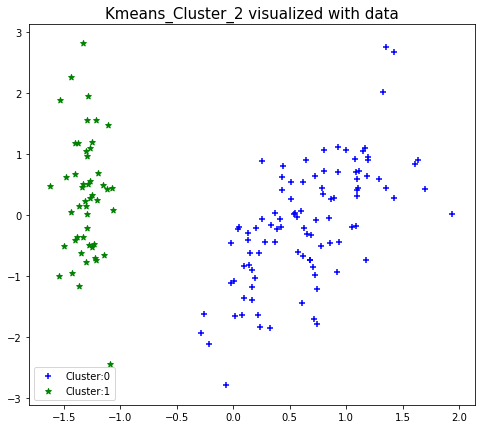









Total found in Cluster:0 is 86


/Users/ericcacciavillani/anaconda3/envs/Data_Sci/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ericcacciavillani/anaconda3/envs/Data_Sci/lib/python3.6/site-packages/scipy/stats/stats.py:2253: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Cluster:0,6.2,2.9,4.9,1.7,1


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Mean,6.216279,2.890698,4.852326,1.667442,1.476744
Min,5.000000,2.300000,3.300000,1.000000,1.000000
Median,6.300000,2.900000,4.850000,1.600000,1.000000
Max,7.400000,3.400000,6.300000,2.500000,2.000000
Standard Deviation,0.519017,0.264632,0.681819,0.405388,0.502388
Variance,0.269379,0.070030,0.464877,0.164339,0.252394









Total found in Cluster:1 is 40


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Cluster:1,5.0,3.4,1.5,0.2,0


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Mean,4.997500,3.397500,1.462500,0.230000,0.0
Min,4.400000,2.900000,1.200000,0.100000,0.0
Median,5.000000,3.400000,1.500000,0.200000,0.0
Max,5.700000,4.100000,1.700000,0.400000,0.0
Standard Deviation,0.310077,0.299133,0.121291,0.082275,0.0
Variance,0.096147,0.089481,0.014712,0.006769,0.0









Orginal points in dataframe:  150
Total points in all modified clusters:  126
Shrank by:  24


,petal length (cm),petal width (cm),sepal length (cm),sepal width (cm),species
Cluster:0,4.9,1.7,6.2,2.9,Versicolor
Cluster:1,1.5,0.2,5.0,3.4,Setosa







--------------------------------------------------------------------------------


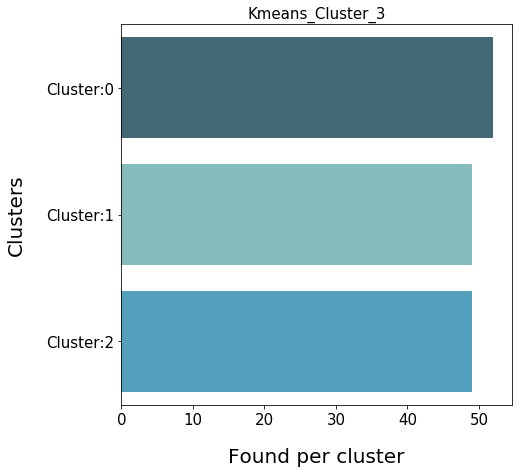

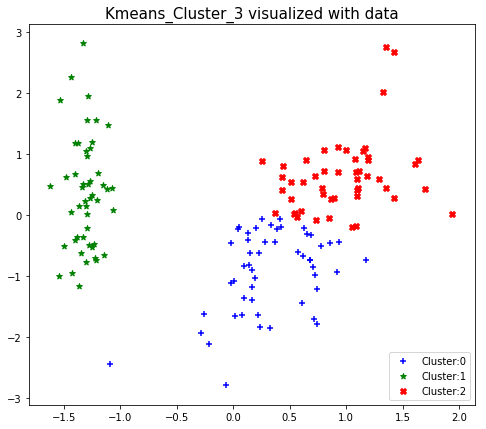









Total found in Cluster:0 is 48


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Cluster:0,5.8,2.7,4.4,1.4,1


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Mean,5.802083,2.660417,4.358333,1.397917,1.250000
Min,4.900000,2.200000,3.000000,1.000000,1.000000
Median,5.800000,2.700000,4.350000,1.300000,1.000000
Max,6.500000,3.000000,5.600000,2.000000,2.000000
Standard Deviation,0.399196,0.231314,0.566375,0.284709,0.437595
Variance,0.159357,0.053506,0.320780,0.081059,0.191489









Total found in Cluster:1 is 40


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Cluster:1,5.0,3.4,1.5,0.2,0


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Mean,4.997500,3.397500,1.462500,0.230000,0.0
Min,4.400000,2.900000,1.200000,0.100000,0.0
Median,5.000000,3.400000,1.500000,0.200000,0.0
Max,5.700000,4.100000,1.700000,0.400000,0.0
Standard Deviation,0.310077,0.299133,0.121291,0.082275,0.0
Variance,0.096147,0.089481,0.014712,0.006769,0.0









Total found in Cluster:2 is 45


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Cluster:2,6.7,3.1,5.4,1.9,2


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Mean,6.660000,3.075556,5.353333,1.917778,1.711111
Min,5.900000,2.800000,4.400000,1.300000,1.000000
Median,6.700000,3.000000,5.400000,1.900000,2.000000
Max,7.700000,3.400000,6.700000,2.500000,2.000000
Standard Deviation,0.452970,0.165359,0.590300,0.345943,0.458368
Variance,0.205182,0.027343,0.348455,0.119677,0.210101









Orginal points in dataframe:  150
Total points in all modified clusters:  133
Shrank by:  17


,petal length (cm),petal width (cm),sepal length (cm),sepal width (cm),species
Cluster:0,4.4,1.4,5.8,2.7,Versicolor
Cluster:1,1.5,0.2,5.0,3.4,Setosa
Cluster:2,5.4,1.9,6.7,3.1,Virginica







--------------------------------------------------------------------------------


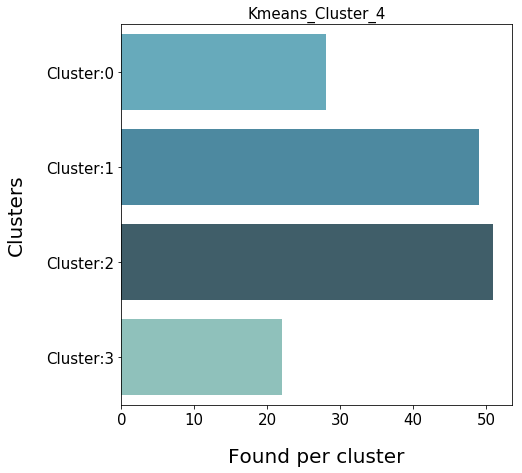

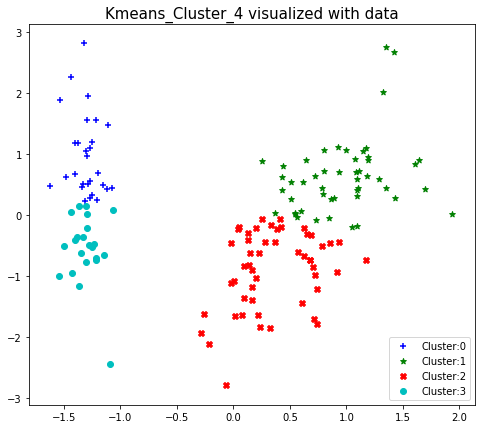









Total found in Cluster:0 is 23


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Cluster:0,5.2,3.6,1.5,0.3,0


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Mean,5.221739,3.639130,1.482609,0.252174,0.0
Min,4.900000,3.400000,1.300000,0.100000,0.0
Median,5.200000,3.600000,1.500000,0.200000,0.0
Max,5.700000,4.200000,1.700000,0.400000,0.0
Standard Deviation,0.206610,0.233041,0.119286,0.094722,0.0
Variance,0.042688,0.054308,0.014229,0.008972,0.0









Total found in Cluster:1 is 45


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Cluster:1,6.7,3.1,5.4,1.9,2


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Mean,6.660000,3.075556,5.353333,1.917778,1.711111
Min,5.900000,2.800000,4.400000,1.300000,1.000000
Median,6.700000,3.000000,5.400000,1.900000,2.000000
Max,7.700000,3.400000,6.700000,2.500000,2.000000
Standard Deviation,0.452970,0.165359,0.590300,0.345943,0.458368
Variance,0.205182,0.027343,0.348455,0.119677,0.210101









Total found in Cluster:2 is 44


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Cluster:2,5.9,2.7,4.4,1.4,1


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Mean,5.852273,2.675000,4.381818,1.406818,1.227273
Min,5.000000,2.200000,3.300000,1.000000,1.000000
Median,5.800000,2.700000,4.350000,1.300000,1.000000
Max,6.500000,3.000000,5.300000,2.000000,2.000000
Standard Deviation,0.346738,0.235387,0.494750,0.283990,0.423915
Variance,0.120227,0.055407,0.244778,0.080650,0.179704









Total found in Cluster:3 is 18


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Cluster:3,4.7,3.1,1.4,0.2,0


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Mean,4.738889,3.133333,1.433333,0.200000,0.0
Min,4.400000,2.900000,1.200000,0.100000,0.0
Median,4.800000,3.100000,1.400000,0.200000,0.0
Max,5.000000,3.400000,1.600000,0.300000,0.0
Standard Deviation,0.203322,0.141421,0.118818,0.048507,0.0
Variance,0.041340,0.020000,0.014118,0.002353,0.0









Orginal points in dataframe:  150
Total points in all modified clusters:  130
Shrank by:  20


,petal length (cm),petal width (cm),sepal length (cm),sepal width (cm),species
Cluster:0,1.5,0.3,5.2,3.6,Setosa
Cluster:1,5.4,1.9,6.7,3.1,Virginica
Cluster:2,4.4,1.4,5.9,2.7,Versicolor
Cluster:3,1.4,0.2,4.7,3.1,Setosa







--------------------------------------------------------------------------------


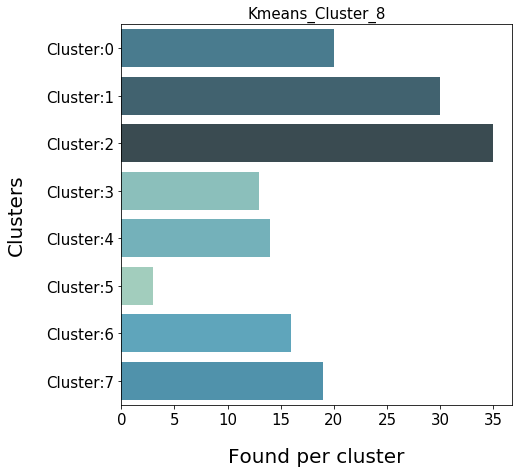

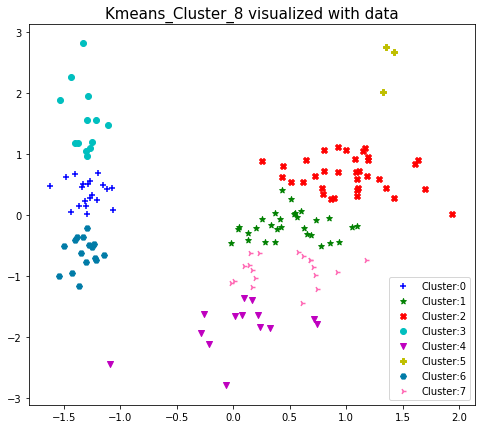









Total found in Cluster:0 is 17


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Cluster:0,5.1,3.4,1.5,0.3,0


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Mean,5.082353,3.441176,1.470588,0.252941,0.0
Min,4.600000,3.300000,1.300000,0.100000,0.0
Median,5.100000,3.400000,1.400000,0.200000,0.0
Max,5.500000,3.600000,1.700000,0.500000,0.0
Standard Deviation,0.221459,0.087026,0.121268,0.100733,0.0
Variance,0.049044,0.007574,0.014706,0.010147,0.0









Total found in Cluster:1 is 24


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Cluster:1,6.1,2.9,4.7,1.5,1


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Mean,6.129167,2.895833,4.666667,1.529167,1.375000
Min,5.600000,2.700000,4.000000,1.200000,1.000000
Median,6.100000,2.900000,4.600000,1.500000,1.000000
Max,6.600000,3.000000,5.600000,2.100000,2.000000
Standard Deviation,0.292633,0.099909,0.441998,0.254489,0.494535
Variance,0.085634,0.009982,0.195362,0.064764,0.244565









Total found in Cluster:2 is 32


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Cluster:2,6.7,3.1,5.4,2.0,2


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Mean,6.725000,3.131250,5.415625,1.975000,1.750000
Min,6.000000,2.800000,4.400000,1.400000,1.000000
Median,6.700000,3.100000,5.500000,2.050000,2.000000
Max,7.600000,3.400000,6.600000,2.500000,2.000000
Standard Deviation,0.368957,0.149056,0.551309,0.342665,0.439941
Variance,0.136129,0.022218,0.303942,0.117419,0.193548









Total found in Cluster:3 is 11


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Cluster:3,5.4,3.9,1.5,0.3,0


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Mean,5.363636,3.872727,1.490909,0.263636,0.0
Min,5.100000,3.700000,1.200000,0.100000,0.0
Median,5.400000,3.800000,1.500000,0.200000,0.0
Max,5.800000,4.200000,1.700000,0.400000,0.0
Standard Deviation,0.237793,0.167874,0.151357,0.102691,0.0
Variance,0.056545,0.028182,0.022909,0.010545,0.0









Total found in Cluster:4 is 12


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Cluster:4,5.5,2.4,3.9,1.2,1


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Mean,5.475000,2.366667,3.916667,1.216667,1.166667
Min,4.900000,2.200000,3.000000,1.000000,1.000000
Median,5.500000,2.400000,3.950000,1.100000,1.000000
Max,6.200000,2.500000,5.000000,1.700000,2.000000
Standard Deviation,0.439266,0.123091,0.567023,0.240580,0.389249
Variance,0.192955,0.015152,0.321515,0.057879,0.151515









Total found in Cluster:5 is 3


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Cluster:5,7.6,3.7,6.4,2.2,2


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Mean,7.600000,3.733333,6.40,2.233333,2.0
Min,7.200000,3.600000,6.10,2.000000,2.0
Median,7.700000,3.800000,6.40,2.200000,2.0
Max,7.900000,3.800000,6.70,2.500000,2.0
Standard Deviation,0.360555,0.115470,0.30,0.251661,0.0
Variance,0.130000,0.013333,0.09,0.063333,0.0









Total found in Cluster:6 is 14


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Cluster:6,4.7,3.1,1.4,0.2,0


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Mean,4.721429,3.092857,1.428571,0.185714,0.0
Min,4.400000,2.900000,1.200000,0.100000,0.0
Median,4.750000,3.100000,1.400000,0.200000,0.0
Max,5.000000,3.200000,1.600000,0.200000,0.0
Standard Deviation,0.215473,0.099725,0.126665,0.036314,0.0
Variance,0.046429,0.009945,0.016044,0.001319,0.0









Total found in Cluster:7 is 17


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Cluster:7,5.8,2.7,4.5,1.5,1


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Mean,5.788235,2.658824,4.547059,1.476471,1.352941
Min,5.200000,2.500000,3.500000,1.000000,1.000000
Median,5.800000,2.700000,4.500000,1.400000,1.000000
Max,6.300000,2.800000,5.600000,2.000000,2.000000
Standard Deviation,0.273593,0.100367,0.584292,0.343747,0.492592
Variance,0.074853,0.010074,0.341397,0.118162,0.242647









Orginal points in dataframe:  150
Total points in all modified clusters:  130
Shrank by:  20


,petal length (cm),petal width (cm),sepal length (cm),sepal width (cm),species
Cluster:0,1.5,0.3,5.1,3.4,Setosa
Cluster:1,4.7,1.5,6.1,2.9,Versicolor
Cluster:2,5.4,2.0,6.7,3.1,Virginica
Cluster:3,1.5,0.3,5.4,3.9,Setosa
Cluster:4,3.9,1.2,5.5,2.4,Versicolor
Cluster:5,6.4,2.2,7.6,3.7,Virginica
Cluster:6,1.4,0.2,4.7,3.1,Setosa
Cluster:7,4.5,1.5,5.8,2.7,Versicolor







--------------------------------------------------------------------------------


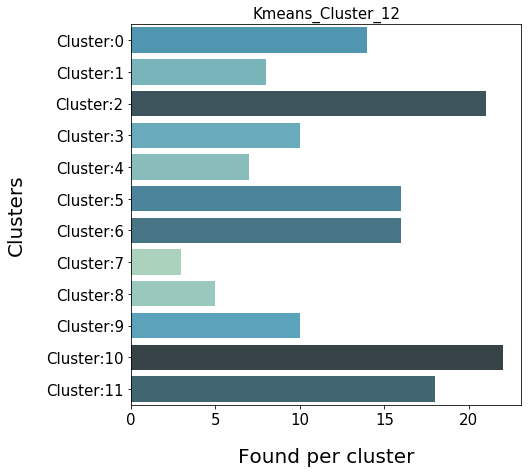

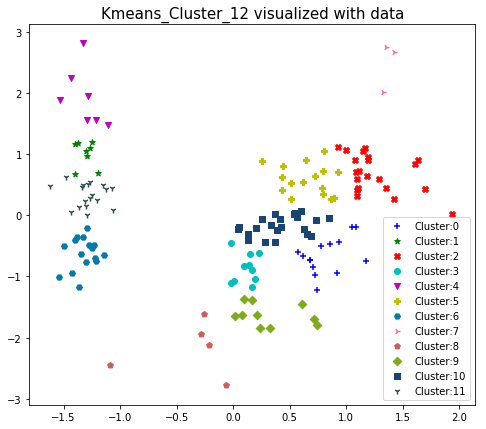









Total found in Cluster:0 is 13


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Cluster:0,6.1,2.7,5.2,1.8,2


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Mean,6.138462,2.653846,5.223077,1.846154,1.846154
Min,5.600000,2.500000,4.900000,1.400000,1.000000
Median,6.300000,2.700000,5.100000,1.900000,2.000000
Max,6.700000,2.800000,5.800000,2.200000,2.000000
Standard Deviation,0.333013,0.119829,0.319254,0.229548,0.375534
Variance,0.110897,0.014359,0.101923,0.052692,0.141026









Total found in Cluster:1 is 6


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Cluster:1,5.2,3.7,1.5,0.2,0


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Mean,5.166667,3.716667,1.500000,0.250000,0.0
Min,5.000000,3.600000,1.400000,0.200000,0.0
Median,5.100000,3.700000,1.500000,0.200000,0.0
Max,5.400000,3.800000,1.600000,0.400000,0.0
Standard Deviation,0.150555,0.075277,0.063246,0.083666,0.0
Variance,0.022667,0.005667,0.004000,0.007000,0.0









Total found in Cluster:2 is 19


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Cluster:2,7.0,3.1,5.8,2.2,2


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Mean,6.957895,3.089474,5.836842,2.184211,2.0
Min,6.300000,2.800000,5.100000,1.800000,2.0
Median,6.900000,3.100000,5.800000,2.200000,2.0
Max,7.700000,3.400000,6.700000,2.500000,2.0
Standard Deviation,0.428584,0.169623,0.419273,0.211511,0.0
Variance,0.183684,0.028772,0.175789,0.044737,0.0









Total found in Cluster:3 is 8


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Cluster:3,5.7,2.7,4.1,1.2,1


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Mean,5.700000,2.687500,4.087500,1.187500,1.0
Min,5.500000,2.600000,3.500000,1.000000,1.0
Median,5.700000,2.700000,4.100000,1.200000,1.0
Max,5.800000,2.800000,4.500000,1.300000,1.0
Standard Deviation,0.106904,0.083452,0.309089,0.124642,0.0
Variance,0.011429,0.006964,0.095536,0.015536,0.0









Total found in Cluster:4 is 7


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Cluster:4,5.5,4.0,1.5,0.3,0


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Mean,5.528571,4.042857,1.471429,0.285714,0.0
Min,5.200000,3.800000,1.200000,0.100000,0.0
Median,5.500000,4.000000,1.500000,0.300000,0.0
Max,5.800000,4.400000,1.700000,0.400000,0.0
Standard Deviation,0.213809,0.207020,0.188982,0.121499,0.0
Variance,0.045714,0.042857,0.035714,0.014762,0.0









Total found in Cluster:5 is 15


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Cluster:5,6.5,3.2,4.9,1.7,1


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Mean,6.520000,3.153333,4.920000,1.720000,1.400000
Min,6.000000,3.000000,4.400000,1.400000,1.000000
Median,6.500000,3.100000,4.900000,1.600000,1.000000
Max,7.000000,3.400000,5.500000,2.300000,2.000000
Standard Deviation,0.259670,0.135576,0.396773,0.307525,0.507093
Variance,0.067429,0.018381,0.157429,0.094571,0.257143









Total found in Cluster:6 is 14


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Cluster:6,4.7,3.1,1.4,0.2,0


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Mean,4.721429,3.092857,1.428571,0.185714,0.0
Min,4.400000,2.900000,1.200000,0.100000,0.0
Median,4.750000,3.100000,1.400000,0.200000,0.0
Max,5.000000,3.200000,1.600000,0.200000,0.0
Standard Deviation,0.215473,0.099725,0.126665,0.036314,0.0
Variance,0.046429,0.009945,0.016044,0.001319,0.0









Total found in Cluster:7 is 3


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Cluster:7,7.6,3.7,6.4,2.2,2


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Mean,7.600000,3.733333,6.40,2.233333,2.0
Min,7.200000,3.600000,6.10,2.000000,2.0
Median,7.700000,3.800000,6.40,2.200000,2.0
Max,7.900000,3.800000,6.70,2.500000,2.0
Standard Deviation,0.360555,0.115470,0.30,0.251661,0.0
Variance,0.130000,0.013333,0.09,0.063333,0.0









Total found in Cluster:8 is 5


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Cluster:8,4.9,2.3,3.0,1.0,1


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Mean,4.900000,2.300000,2.88000,0.880000,0.800000
Min,4.500000,2.000000,1.30000,0.300000,0.000000
Median,5.000000,2.300000,3.30000,1.000000,1.000000
Max,5.100000,2.500000,3.50000,1.100000,1.000000
Standard Deviation,0.234521,0.187083,0.90111,0.327109,0.447214
Variance,0.055000,0.035000,0.81200,0.107000,0.200000









Total found in Cluster:9 is 9


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Cluster:9,5.7,2.4,4.1,1.3,1


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Mean,5.666667,2.366667,4.088889,1.255556,1.111111
Min,4.900000,2.200000,3.700000,1.000000,1.000000
Median,5.500000,2.400000,4.000000,1.300000,1.000000
Max,6.300000,2.500000,4.500000,1.700000,2.000000
Standard Deviation,0.433013,0.122474,0.301846,0.235112,0.333333
Variance,0.187500,0.015000,0.091111,0.055278,0.111111









Total found in Cluster:10 is 19


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Cluster:10,6.1,2.9,4.5,1.5,1


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Mean,6.057895,2.915789,4.536842,1.457895,1.263158
Min,5.600000,2.800000,4.000000,1.200000,1.000000
Median,6.100000,2.900000,4.600000,1.400000,1.000000
Max,6.600000,3.000000,5.100000,1.800000,2.000000
Standard Deviation,0.283462,0.083421,0.325253,0.206332,0.452414
Variance,0.080351,0.006959,0.105789,0.042573,0.204678









Total found in Cluster:11 is 15


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Cluster:11,5.1,3.4,1.5,0.3,0


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Mean,5.060000,3.426667,1.486667,0.260000,0.0
Min,4.600000,3.300000,1.300000,0.100000,0.0
Median,5.100000,3.400000,1.500000,0.200000,0.0
Max,5.400000,3.600000,1.700000,0.500000,0.0
Standard Deviation,0.206328,0.079881,0.118723,0.105560,0.0
Variance,0.042571,0.006381,0.014095,0.011143,0.0









Orginal points in dataframe:  150
Total points in all modified clusters:  133
Shrank by:  17


,petal length (cm),petal width (cm),sepal length (cm),sepal width (cm),species
Cluster:0,5.2,1.8,6.1,2.7,Virginica
Cluster:1,1.5,0.2,5.2,3.7,Setosa
Cluster:2,5.8,2.2,7.0,3.1,Virginica
Cluster:3,4.1,1.2,5.7,2.7,Versicolor
Cluster:4,1.5,0.3,5.5,4.0,Setosa
Cluster:5,4.9,1.7,6.5,3.2,Versicolor
Cluster:6,1.4,0.2,4.7,3.1,Setosa
Cluster:7,6.4,2.2,7.6,3.7,Virginica
Cluster:8,3.0,1.0,4.9,2.3,Versicolor
Cluster:9,4.1,1.3,5.7,2.4,Versicolor







--------------------------------------------------------------------------------


In [16]:
cluster_maintainer.evaluate_all_models(restore_df,
                                       df_features,
                                       le_map,
                                       zscore_low=-2,
                                       zscore_high=2,
                                       find_nearest_on_cols=True)

In [17]:
cluster_maintainer.labels_

AttributeError: 'ClusterMaster' object has no attribute 'labels_'